**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Curso: Inteligencia Artificial**

**Primer Semestre 2021**

**Profesor: Luis-Alexander Calvo-Valverde**

**Trabajo Corto:** 05

**Datos de la entrega:** Viernes 11 de junio 2021, a más tardar a las 11:59 pm

**Estudiantes:**
- Luis Adrián Badilla Godínez
- Jorge Eduardo Gutiérrez Mata


# Parte 1: Aprendizaje por refuerzo


Luego de estudiar el siguiente recurso: https://www.youtube.com/watch?v=u3UjPSJQCT4 (del inicio hasta 01:06:00) debe presentar lo siguiente:
1. Un resumen del contenido del video. (**10 puntos**)
1. Busque en internet un programa en python que implemente aprendizaje por refuerzo y agregue comentarios amplios (en español) donde va explicando el código y cómo la teoría estudiada en el punto anterior se aplica. (**20 puntos**). (Debe aportar todo lo necesario para que el profesor pueda correr dicho código).


### Resumen del vídeo

### Introducción al Reinforcement Learning
#### Definiciones
1. **IA:** El área que estudia máquinas que están alcanzando un nivel de rendimiento humano en una tarea específica, ya sea reconocer spam, fraudes, rostros. En palabras técnicas es el campo que estudia agentes inteligentes que perciben su ambiante y realizan acciones con la finalidad de resolver una tarea.

1. **Machine Learning:** Son todos los algoritmos que son capaces de enseñar a la computadora una tarea humana por medio de la experiencia con la finalidad de aumentar el rendimiento gracias a esta.

##### **Tipos de tareas**
Percepción es la que se refiera a clasificar correctamente (como perros y gatos).
Acción son los tipos de tareas que requieren múltiples acciones que se dividen en subtareas, como el tener un vehículo autónomo que defina una ruta para moverse del punto A al B. Estas son las tareas de acción

El rendimiento es específico de la tarea que queramos solucionar, es decir depende al área en la que estemos. Usando ejemplos reales para el vehículo autónomo pone el tiempo que dura en llegar, el combustible que gasta, entre otros.

La experiencia le da al algoritmo la habilidad de generalizar, gracias a ella podemos dividir los algoritmos en supervisado, no supervisado y el aprendizaje por refuerzo.

#### Paradigmas
Como hemos visto en el curso, el aprendizaje supervisado es aquel que maneja problemas de clasificación y de regresión, estos buscan predecir un número, una etiqueta o un valor booleano. Pone como ejemplo obtener a futuro los ingresos de una empresa así cómo clasificar un caso de cáncer y no cáncer.

Lo que es el aprendizaje no supervisado se divide en Clustering (agrupamiento) como por ejemplo un algoritmo que detecte fraudes que se realizan con tarjetas de crédito, para ello busca anomalías o patrones fuera de lo común.

El aprendizaje reforzado (RL) es un híbrido entre ambos, hay una etapa de entranamiento pero no se le dice el resultado correcto, se le dan recompenzas dependiendo de las acciones que vaya realizando, así por sí solo se da cuenta de cuales acciones le permiten obtener una mayor recompensa. Se usan cuando queremos solucionar las **tareas de acción** como para saber cuándo comprar y vender acciones.

#### RL History
1. Nace con Edward Thorndike con la ley de causa y efecto y la ley de prueba y error. (Los animales aprenden asociando con recompensas).

1. Richard Bellman con la teoría de control óptimo, la programación dinámica y la ecuación de Bellman.

1. Chris Watkins habló sobre la diferencia temporal y el algoritmo Q learning.

1. Se habla de Deep mind y alpha GO, también crearon alphaFold que es capáz de producir la síntesis de una estructuras de proteínas (tarea muy compleja).

#### Conceptos básicos de RL
1. Ambiente: el mundo en el que vive la IA. EJ: el vehículo autónomo viaja por la ruta 27 de San José a Caldera.

1. Agente: Es la IA tratando de solucionar la tarea, o sea el vehículo autónomo. Su meta es maximizar la recompensa total a través de los estados apropiados.

1. Las acciones: decisiones que toma el agente para solucionar la terea como acelerar, frenar, etc.

1. Estados: configuraciones del ambiente, en este caso el saber que hay un peaje con 6 carriles, pasar por túneles, cambio de tipo de carretera.

1. Recompensa: Son números enteros (-,+).

1. Policy: Es el criterio que usa el IA para escoger las acciones. Ej: llegar a Caldera en el menor tiempo posible, entonces él vehículo tendría que preveer las acciones para cumplir con el objetivo

La finalidad del aprendizaje reforzado es darle al agente de una forma de aprender a por medio de la experiencia. Se busca que seleccione acciones convenientes, que lo dirijan a estados apropiados del ambiante para maximizar la recompensa.

##### Proceso estocástico
Es un proceso que implica cierta aleatoriedad en el ambiente, como ejemplo pone un dron que intenta desplegar un líquido para apagar un incendio, aquí damos por un hecho que no siempre que el dron quiera cumplir con su objetivo lo va a lograr.

##### Proceso de decisión de Markov
La probabilidad de que se desplaze el drón depende del estado actual. No se modela con momentos anteriores.

1. Tareas episódica: aquellas que se pueden repetir como las partidas de ajedréz.
1. Tareas continuas: son la que no se reinician como una IA que controle la temperatura en el edificio.

#### Ecuación de Bellman (Intuición)
Perminte relacionar el valor del estado actual con el de futuros estados sin tener que esperar para observar las futuras recompensas.

Aquí ponen como ejemplo un agente que moviliza cajas en bodegas de Amazón. El agente se mueve en una matríz, hay casillas que tienen valores positivos y negativos según el cumplimiento de la meta del agente (estado final o estado por evitar) y casillas que no tienen valores con la finalidad de que el agente llega a su meta.

Nos comenta que inicialmente el robotcito no tiene criterio para saber a dónde debería ir, para ello se le coloca un Policy aleatorio (el criterio por el cual la IA realiza las acciones, se usan probabilidades para ello); este se va modificando conforme se vayan realizando más pruebas con las funciones de valor.

El valor de un estado depende del valor esperado de todas las posibles recompensas que se pueden obtener al estar en ese estado. 

La idea es irse moviendo entre estos estados, si al moverse el estado no tiene ningún valor, a la casilla de donde venía, se le asigna un 0, en cambio, si al moverse a una casilla llega a un estado positivo (1) entonces a la casilla anterior se le agrega el 1. Lo mismo ocurre con los valores negativos.

Es gracias a este factor que en la siguientes iteraciones del algoritmo se conozcan el valor real que debe optener a partir del policy seleccionado.

Como la idea de calcular el estado se puede representar como el cálculo del valor esperado de la recompensa imnediata + el valor del siguiente estado por lo que tienen un factor de recursividad, pero bajo nuestro contexto le llamamos **retropropagación.**

El detalle es que no se puede asegurar que se va a tomar siempre el camino correcto. Para ello surge el concepto del **Factor de descuento** el cual ayuda a disminuir la insertidumbre en la decisión y afirma que la única certeza que tenemos es sobre la recompensa inmediata. Este le resta un poco a las recompensas que se van estimando en el futuro (un factor gamma), dándole peso así a la decisión imnediata.

También se agrega el **Valor para estado acción** con la finalidad de realizar un mejor cálculo del camino, para ello se le dice al agente que seleccione la acción que le permita maximizar el valor de "q" siendo este un conjunto "Estado-acción".

Esto se realiza con un calculo entre la sumatoria de las recompensas al escoger por cada acción entre el número de veces que se seleccionó esa acción.
(argmax q*acción) por lo que siempre escogerá el estado que le brinde mayor recompensa.

Para terminar de asegurar la funcionalidad del algoritmo se le agrega un **factor de aleatoriedad** esta es una probabilidad sobre la acción que le corresponde ejecutar, pues se desarrolla en un ambiente estocástico. Luego de eso se puede lograr generar un modelo que conozca exactamente por donde se debe movilizar.

Es importante resaltar que incluso aunque el robotcito ya conozca la ruta adecuada para llegar a las bodegas se debe dejar la posibilidad de que este siga explorando, pues puede que haya algún cambio en el ambiente, esto se raliza con la fórmula Epsilon-Greedy donde uno puede indicarle que en un pequeño % de veces no seleccione la acción "correcta" sino una al azar.

Para  concluir con el resúmen, se hace mención del concepto de diferencia temporal, la cual se utiliza entre iteraciones con la finalidad de modificar los pesos entre las mismas, donde se utiliza la fórmula de Bellman - el valor antiguo de cada peso multiplicado con un learning rate con la finalidad de tener mejores resultados.

## Ejemplo en Python: *Self-Driving Cab*

**NOTA: EL SIGUIENTE EJERCICIO SE ENCUENTRA BASADO EN EL CÓDIGO DE LOS DESARROLLADORES SATWIK KANSAL Y BRENAN MARTIN**

El objetivo de mismo es utilizar técnicas de aprendizaje por refuerzo para que el Taxi pueda mover pasajeros en un parqueo tomando en cuenta las siguientes consideraciones:
1. Que deje al pasajero en la locación correcta
1. Cuide el tiempo del pasajero, tomando el menor tiempo posible para dejarlo.
1. Tenga en cuenta la seguridad del pasajero y considere todas las reglas de tráfico.

Para este problema debemos primero considerar 3 cosas:

### Recompensas

En primer lugar hay que escoger las recompensas, penalidades y sus magnitudes respectivas. Para esto se puede tomar en cuenta los siguientes puntos:

1. El agente debe recibir una alta recompensa para un viaje exitoso, es decir deja al pasajero en el destino correcto, esto ya que es un comportamiento altamente deseable.
1. El agente debe penalizarse si trata de dejar al pasajero en una locacion incorrecta.
1. El agente debe ser penalizado levemente por no llegar al destino a tiempo. Levemente debido a que se prefiere que el agente llegue tarde en lugar de hacer movimientos incorrectos, para llegar antes al destino.
    

### Espacio de estados

Este es el conjunto de todas las posibles situaciones en las que podría existir nuestro taxi. Contiene información útil para que el agente pueda tomar la acción correcta.

Como se menciona en este caso se presenta un área de estacionamiento para entrenar, un espacio que se podría modelar como una matriz de 5x5, con cuatro ubicaciones válidas para dejar y recoger pasajeros (*R*,*G*,*Y*,*B*) o ((0,0),(0,4),(4,0),(4,3)) respectivamente.

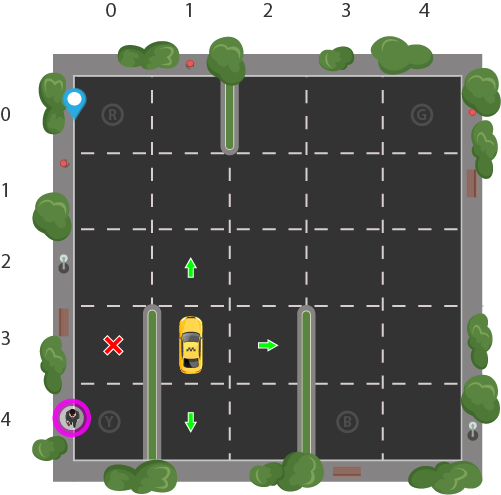

In [2]:
from IPython.display import Image

Image('estacionamiento.png')

Observe que la ubicación actual del taxi es (3,1). El pasajero se encuentra en la ubicación *Y* y desea ir a la ubicación *R*.
Cuando se contabiliza al pasajero dentro del taxi se contempla un estado extra para cada posible posición. Así tomando todas las combinaciones de locaciones del pasajero, locaciones destino y posiciones en el estacionamiento podemos calcular nuestro total de estados posibles:

$5x5x5x4=500$ 

### Espacio de acciones

Dentro de alguno de los estados el taxi debe tomar una acción, además de moverse en alguna de las cuatro direcciones, este también tiene la capacidad de recoger o dejar a un pasajero, por lo que nuestro conjunto de acciones será:

1. Sur
1. Norte
1. Este
1. Oeste
1. Recoger
1. Dejar

Este es el espacio de acciones: todos las acciones que el agente puede tomar estando en un estado determinado.

Se puede notar en la imagen anterior hay ciertas acciones en ciertos estados que se consideran inválidas, en el código del entorno simplemente se penaliza con -1 cualquier golpe a una pared, por lo que el taxi no se moverá. Esto con el entrenamiento hará que el taxi considere dar la vuelta a la pared.

### Implementación en Python con Gym

En este caso la librería *Gym* de *OpenAI* tiene este caso concreto ya construido para visualizarlo.

*Gym* proporciona diferentes entornos de jeugo que podemos conectar a código nuestro para probar un agente. La librería se encarga de proveer toda la información que el agente puede requerir como acciones, puntaje y estado actual. Así solamente nos centramos en el algoritmo para el agente. 

En este caso el entorno utilizado será *Taxi-v2* el cual ya proporciona toda la información mencionada anteriormente.

In [2]:
!pip3 install scikit-build

     |████████████████████████████████| 81kB 5.4MB/s eta 0:00:011


In [3]:
!pip3 install cmake 'gym[atari]' scipy

In [8]:
import gym

# env corresponde a la interfaz unificada para el entorno
# en este podemos encontrar métodos útiles, entre estos:

# env.reset() (reinicia el ambiente y retorna un estado inicial aleatorio)
# env.step(action) (avanza un paso el ambiente por un paso de tiempo, retorna:
#    observation: observaciones del ambiente
#    reward: si la acción fue beneficiosa o no
#    done: indica si se ha recogido y dejado un pasajero exitosamente, también se llama episode
#    info: información adicional como rendimiento y latencia para debugging)
# env.render() (renderiza un frame del ambiente, útil para la visualización)
env = gym.make("Taxi-v3").env 

# aquí se utiliza .env al final del make para evitar deter el entrenamiento en
# la iteración 200 que es el default para cada versión nueva de Gym

In [14]:
env.reset()  # reinicia el ambiente a un estado aleatorio
env.render()  # lo renderiza para visualizar

print("Tamaño del espacio de acciones: ", format(env.action_space.n))
print("Tamaño del espacio de estados: ", format(env.observation_space.n))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Tamaño del espacio de acciones:  6
Tamaño del espacio de estados:  500


Como se puede observar en el render, este consta de 3 partes, el cuadrado amarillo que representa al taxi sin pasajero (verde con pasajero), las barras ( **|** ) que representan las paredes que el taxi no puede cruzar y las cuatro posiciones (*R*, *G*, *Y* y *B*), la de color azul representa la ubicación de recogida y la roja la ubicación de destino. Así como verificado por *prints* podemos observar un espacio de acciones de tamaño 6 y un espacio de estados de tamaño 500.

Lo único necesario ya es tener una codificación por medio de un número único para cada uno de los estados posibles, y la codificación del 0 al 5 para las acciones. 

El algoritmo de *RL* aprenderá un mapeo de los estados para la acción optima a realizar por medio de exploración. Es decir el agente explora el entorno y toma acciones basadas en las recompensas que puede obtener del entorno.

La acción optima para cada estado es la que tiene mayor recompensa acumulativa a largo plazo.

In [10]:
state = env.encode(3, 1, 2, 0)  # parámetros son:
                                #     3: fila del taxi
                                #     1: columna del taxi
                                #     2: indice del punto donde se encuentra el pasajero
                                #     0: indice del punto de destino

print("Estado: ", state)  # se imprime el numero de estado

env.s = state  # se asigna el nuevo estado
env.render()  # se visualiza el estado

Estado:  328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



En este caso se puede ver cómo utilizamos *env.encode* para codificar con nuestros parámetros y obtener el número de estado correspondiente a este entre 0 y 499.

Luego, podemos establecer el estado del entorno manuanualmente asignando *state* a *env.s*. 

#### La tabla de recompensas

Cuando se crea el entorno de Taxi, también se crea una tabla de recompensas inicial, llamada *P* que tiene el número de estados como filas y el número de acciones como columnas.

Dado que cada estado está en esta tabla, podemos ver los valores de recompensa predeterminados asignados al estado número 328.

In [11]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

Este diccionario tiene la estructura: ```{action: [(proba, nextState, reward, done)]}```.

De 0 a 5 corresponden a las acciones a realizar: 
* 0: Sur 
* 1: Norte 
* 2: Este
* 3: Oeste
* 4: Recoger
* 5: Dejar

En este entorno, ```probability``` siempre es 1.0.

```nextState``` es el estado en el que se estará si se toma la acción en este índice del diccionario.

Ahí todas las acciones de movimiento cuentan con una ```reward``` de -1, mientras las acciones de recoger/dejar tienen una ```reward``` de -10. Si se estuviera en un estado en que el taxi tiene un pasajero y se encuentra en la posición de destino correcto, se observaría una ```reward``` de 20 en la acción de dejar (5).

```done``` se utiliza para indicarnos cuándo hemos dejado a un pasajero en el lugar correcto. Cada vez que se deja un pasajero con éxito se le llama el final de un **episodio**.



####Q-Learning

Aquí utilizaremos un algoritmo de Q-Learning. Este le permite al agente usar las recompensas del entorno para aprender y que con el tiempo, sepa identificar la mejor acción a realizar en un estado determinado. 

Para esto es necesara una *Tabla Q* la cual almacene valores para recordar si una acción en un estado concreto fue beneficiosa.

Los valores en la *Tabla Q* se denominan *valores Q* y se asignan a una entrada ```(estado,accion)```.

Estos valores se inicializan arbitrariamente y a medida que el agente explora el entorno y recibe recompensas al ejecutar diferentes acciones, los *valores Q* se actualizan mediante la siguiente ecuación:


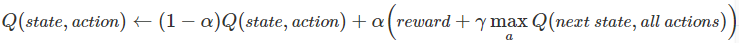

Donde **α** (*alpha*) corresponde al valor del *learning rate* y **γ** (*gamma*) corresponde al factor de descuento, ambos valores entre 0 y 1.

Esta ecuación quiere decir que, se asigna al *valor Q* del estado y acciones actuales, el valor calculado de; un porcentaje *1-α* del antiguo *valor Q*, luego agregando el valor aprendido. Este último es la combinación de la recompensa por realizar la acción actual en el estado actual, y la recompensa máxima descontada del siguiente estado en el que estemos una vez realizada la acción actual.

En resumen, el **Q-Learning** se resume en:
1. Inicialice la *tabla Q* en ceros.
1. Empiece a explorar acciones para cada estado, seleccione cualquiera de las posibles acciones para el estado actual *S*.
1. Muévase al siguiente estado *S'* dada la accion *A*.
1. Para todas las acciones posibles en el estado *S'*, seleccione la que tenga el *valor Q* más alto.
1. Actualice los valores de la *tabla Q* usando la ecuación.
1. Establesca el siguiente estado como el estado actual.
1. Si se alcanza el estado objetivo, finalice y si no, repita el proceso.

#### Explotación de valores aprendidos

Después de mucha exploración aleatoria de acciones, los *valores Q* tienden a converger en valores que le sirven al agente como una función de valor de acción que puede explotar para elegir la acción más óptima de un estado en particular.

En este caso existe una compensación entre la exploración (búsqueda aleatoria) y explotación (elegir acciones basado en *valores Q* ya aprendidos), y se busca evitar que la acción tome siempre la misma ruta y se sobreajuste, por lo que se introduce un nuevo parámetro, *ϵ*. Un valor epsilon bajo da como resultados episodios con más penalizaciones, esto debido a que nos concentramos en explorar tomando decisiones al azar.

#### Implementación del *Q-Learning* en Python

In [15]:
# se importa numpy y se crea la tabla Q con ceros
import numpy as np
qTable = np.zeros( [env.observation_space.n, env.action_space.n] )

In [17]:

# se importan y definen las principales variables para el entrenamiento

import random
from IPython.display import clear_output

# variables hyperparámetros
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# variables para calculos de métricas

all_epochs = []
all_penalties = []

In [20]:
# se entrena
%%time

for i in range(1, 100001):
  state = env.reset()  # selecciona un estado aleatorio

  epochs, penalties, reward = 0, 0, 0
  done = False

  while not done:  # mientras no haya un episodio completo
    if random.uniform(0,1) < epsilon:  # si se cumple el epsilon
      action = env.action_space.sample()  # se explora el espacio
    else:
      action = np.argmax(qTable[state])  # se explotan los valores aprendidos
    
    # se desplaza al estado en la accion tomada
    nextState, reward, done, info = env.step(action)

    # toma el valor anterior
    oldValue = qTable[state, action]

    # toma el siguiente maximo
    nextMax = np.max(qTable[nextState])

    # calcula el nuevo valor
    newValue = (1 - alpha) * oldValue + alpha * (reward + gamma * nextMax)
    
    # setea el nuevo valor
    qTable[state, action] = newValue

    # si se penaliza aumenta el contador
    if reward == -10:
      penalties += 1
    
    # se asigna el nuevo estado
    state = nextState
  
  if i % 100 == 0:
    clear_output(wait=True)
    print(f"Episode:  {i}")
  
print("Entrenamiento terminado")

Episode:  100000
Entrenamiento terminado
CPU times: user 1min 8s, sys: 25 s, total: 1min 33s
Wall time: 1min 11s


In [21]:
# ahora podemos observar el valor en la qTable

qTable[328]

array([ -2.39655291,  -2.27325184,  -2.40260767,  -2.35824346,
       -10.2140601 , -10.41820876])

#### Evaluación con Python

In [23]:
# aquí se realizará la evaluación

# variables para evaluar
total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
  # selecciona un estado al azar
  state = env.reset()

  # inicia los epochs, penalidades, recompensa y done
  epochs, penalties, reward = 0, 0, 0
  done = False

  # verifica mientras no se haya completado un episodio
  while not done:
    # selecciona la acción
    action = np.argmax(qTable[state])

    # se mueve al estado al que lleva la accion elegida
    state, reward, done, info = env.step(action)

    # si la recompensa es negativa
    if reward == -10:
      penalties += 1

    epochs += 1

  total_penalties += penalties
  total_epochs += epochs

print(f"Resultados después de {episodes} episodios:")
print(f"Pasos de tiempo promedio por episodio: {total_epochs / episodes}")
print(f"Penalizaciones promedio por episodio: {total_penalties / episodes}")

Resultados después de 100 episodios:
Pasos de tiempo promedio por episodio: 13.41
Penalizaciones promedio por episodio: 0.0


#### Conclusión de este ejemplo

Como se observa en la evaluación, el desempeño del agente es significativamente bueno, dado que no incurrió en penalizaciones lo que significa que ejecutó las acciones correctas en la recogida y devolución de 100 pasajeros diferentes.

# Parte 2: Adversarial search


Luego de estudiar el siguiente recurso: https://www.youtube.com/watch?v=_3djr6ZXLzQ  (del minuto 00:04:00 hasta el final), debe presentar lo siguiente:
* Presente un mapa mental o uno conceptual, en que resume el tema presentado en el video. (**10 puntos**)


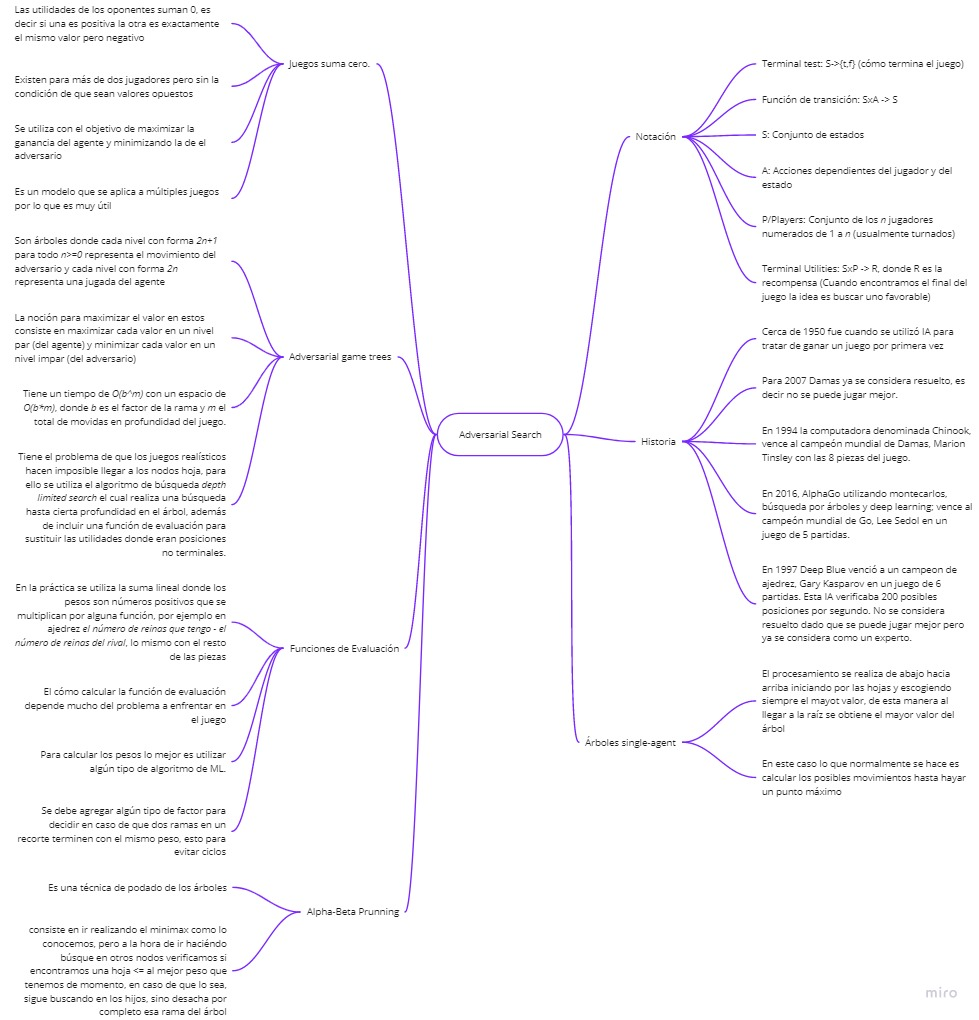

In [4]:
Image('AdversarialSearchMindMap.jpg')

* Dado el game tree que se muestra en la Figura siguiente, responda:
    1. En las cajas punteadas, llene los valores de todos los nodos intenos
usando el algoritmo minimax. (**10 puntos**)
    1. Marque los nodos que no son evaluados cuando se usa alpha-beta pruning (suponiendo el recorrido estándar del árbol de izquierda a derecha). (**10 puntos**)
    1. Explique en una celda de texto el procedimiento seguido para el punto anterior. (**10 puntos**)


### Imagen original

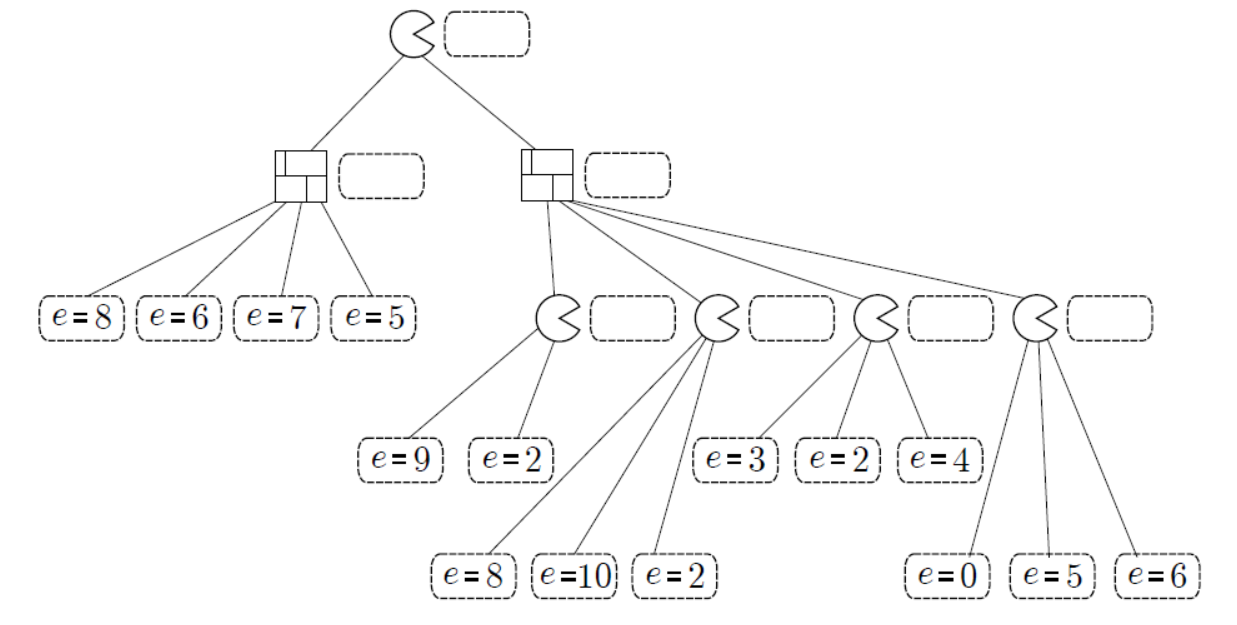

In [ ]:
from IPython.display import Image

Image('grafo.png')

### Resolución de la figura

Para poder llevar a cabo el algoritmo de MinMax, cuando Pacman es el que toma los valores debemos buscar siempre el más alto, con los rivales es el contrario, esto porque la manera en la que está planteada este juego es con *suma zero*, es decir que las utilidades de los oponentes suman 0 y la del jugador, si una es positiva la otra es exactamente el mismo valor pero negativo.

Además, para realizar el proceso acorde al vídeo usamos depth first para ir leyendo el árbol. Por lo que primero entramos con el rival izquierdo, aquí no puede haber ningún corte con prunning dado que es el primer nivel, puesto que debemos encontrar el mínimo seleccionamos al 5 que cumple con lo deseado. Es importante anotar que esta valor va a ser el que nos va a definir qué posible valor más alto o igual a 5 ocuparíamos para que *Pacman* lo seleccione (importa a la hora de hacer el prunning).

Continuando con el árbol, pasamos a la rama derecha, analizamos su primer hijo que es un Pacman, aquí también debemos analizar ambos hijos pues tras analizar el primero aún existe la posibilidad de que el segundo sea mayor. Obtenemos 9 como resultante lo que nos pone otra variable a considerar para el algoritmo de prunning. De aquí en adelante, el valor que llegará al árbol mayor será uno menor o igual a 9 pues es el rival el que escoge la capa superior. 

Si 9 resultara ser el valor más bajo entonces tendría Pacman mejor ganancia pero aún hay posibilidad de reducir el número por lo que seguimos con el siguiente hijo a la derecha. Nos damos cuenta que es un 8, este número cumple con las características de ser <9 y >5 sin embargo, no sería lo ideal para nosotros hacer un corte en el siguiente nodo, pues existe la posibilidad de que aparezca otro 9. Avanzamos un hijo más y notamos que es 10, aquí sucede un evento importante.

Al tener nosotros 10 como resultado, sabemos que, a lo que hemos leido del árbol, si es escogido como el mayor, la capa rival de arriba no lo escogería, esto implica que no vale la pena seguir leyando el resto de hijos hacia la dercha por lo que se detienen las búsquedar y cambiamos de rama.

En la siguiente primero leemos un 3, dado que este número es nuevamente solo conveniente para el rival, nos vemos en la obligación de seguir buscando un número <9 y >5, el siguiente que obtenemos es un 2, como empeoramos, seguimos buscando y como resultado el último hijo es un 4 por lo que sería elegido este para la capa superior. Este resultado reemplazaría al 9 con el que estuvimos trabajando.

Al reemplazar el 9 ocuparíamos encontrar un número <4 y >5, como hacer esta búsqueda realmente no tiene una solución, no se realiza la entrada al siguiente nodo derecho, el nodo final del árbol y automáticamente decidimos que el valor más grande es el del hijo izquierdo de la raíz y terminamos el algoritmo.

# Parte 3: Conceptos


Luego de estudiar el siguiente recurso: https://ruder.io/optimizing-gradient-descent/ , prepare un video de no menos de 10 minutos y no más de 20 minutos, en que explica lo más claraente posible los siguientes conceptos: (**30 puntos**)
1. Momentum
1. Nesterov accelerated gradient
1. RMSprop
1. Adam

**Nota:** Puede usar recursos adicionales en caso de que los requiera para comprender mejor algún concepto antes de explicarlo.

# Bibliografía

Kansal, S., & Martin, B. (2021). Reinforcement Q-learning from scratch in python with OpenAI gym. Retrieved from 
> https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/